# Analisis Predictivo de Series Temporales

-----------


## Modelos en espacio de estados: modelos de Markov escondidos (HMM)

In [1]:
install.packages("astsa")
library("astsa")

options(repr.plot.width=10, repr.plot.height=6) #ajusta tamaño de graficas


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## Modelos en espacio de estados:

La idea de los modelos en espacio de estados es poder representar procesos que tienen una *dinámica interna*, es decir:

 * Poseen un *estado* $x_t$, que evolucione en el tiempo, y que en general no es observable.
 * Podemos medir uno o más valores $y_t$, denominados *observaciones*, y cuyo comportamiento depende del estado $x_t$ en que se encuentra el proceso.
 
### Problemas:

 * Dadas las observaciones $y_0,\ldots,y_n$, ¿como reconstruimos $x_0,\ldots,x_n$?
 * Dado un conjunto de observaciones $y_0,\ldots,y_n$, ¿cómo ajustamos un modelo a la evolución del estado $x$?
 * ¿Como podemos predecir estados/observaciones futuras?

### Diagrama:

![espacio_estados](hmm.png "Estados y obsevaciones")


### Ejemplos de modelos:

 * Modelos con estados continuos y observaciones continuas (sistemas dinámicos de tiempo discreto con ruido)
     
     * Para ello se estudian herramientas matriciales, en particular el filtro de Kalman.
     * Se aplican en general cuando hay un modelo físico subyacente.
     
     
 * Modelos con estados discretos y observaciones discretas o continuas.
     
     * En este caso una buena técnica es usar **Modelos de Markov Escondidos**.
     * Los estados representan situaciones en las que se encuentra el sistema que generan respuestas distintas de acuerdo a ellos (ej: lluvioso/seco, símbolo transmitido 0 o 1, etc.)

## Modelo de Markov Escondido

Es un modelo en espacio de estados que sigue el diagrama anterior donde:

![espacio_estados](hmm.png "Estados y obsevaciones")

* El estado $X$ es discreto, pertenece a un conjunto $E=\{i,j,\ldots\}$ y es gobernado por una *cadena de Markov de tiempo discreto*.

* Las observaciones $Y_t$ son independientes en cada tiempo $t$, y su distribución depende del valor de $X_t$.


### Cadenas de Markov de tiempo discreto

Una cadena de Markov de tiempo discreto es un proceso estocástico $X_t$ que toma valores en un conjunto discreto de *estados* $E=\{i,j,\ldots\}$ y tal que:

$$P(X_{t+1} = j \mid X_t=i,X_0,\ldots,X_{t-1}) = P(X_{t+1} = j \mid X_t=i) = p_{ij}$$ 

A las $p_{ij}$ se le llaman *probabilidades de transición* y se almacenan en una *matriz de transición*:

$$P = (p_{ij}).$$

**Observación:** $p_{ij}\geqslant 0$ para todo $i,j$, y además la suma de las filas de $P$ debe dar $1$.

### Grafo de transiciones

En general a la dinámica de la cadena se la representa por un *grafo de transiciones*, un grafo dirigido donde el valor de la arista $i\to j$ es la probabilidad $p_{ij}$ (solo se ponen aristas si esta prob. no es $0$).


**Ejemplo:**

![cadena](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Markovkate_01.svg/330px-Markovkate_01.svg.png "ejemplo cadena")

En este caso $E=\{E,A\}$ y $P=\begin{pmatrix}
0.3 & 0.7\\ 0.4 & 0.6\end{pmatrix}$

In [2]:
### Ejemplo en R

# simulate discrete Markov chains according to transition matrix P
run.mc.sim <- function( P, num.iters = 50 ) {
  
  # number of possible states
  num.states <- nrow(P)
  
  # stores the states X_t through time
  states     <- numeric(num.iters)

  # initialize variable for first state 
  states[1]    <- 1

  for(t in 2:num.iters) {
    
    # probability vector to simulate next state X_{t+1}
    p  <- P[states[t-1], ]
    
    ## draw from multinomial and determine state
    states[t] <-  which(rmultinom(1, 1, p) == 1)
  }
  return(states)
}

P <- t(matrix(c( 0.3, 0.7 ,
                 0.4, 0.6 ), nrow=2, ncol=2))
P

0.3,0.7
0.4,0.6


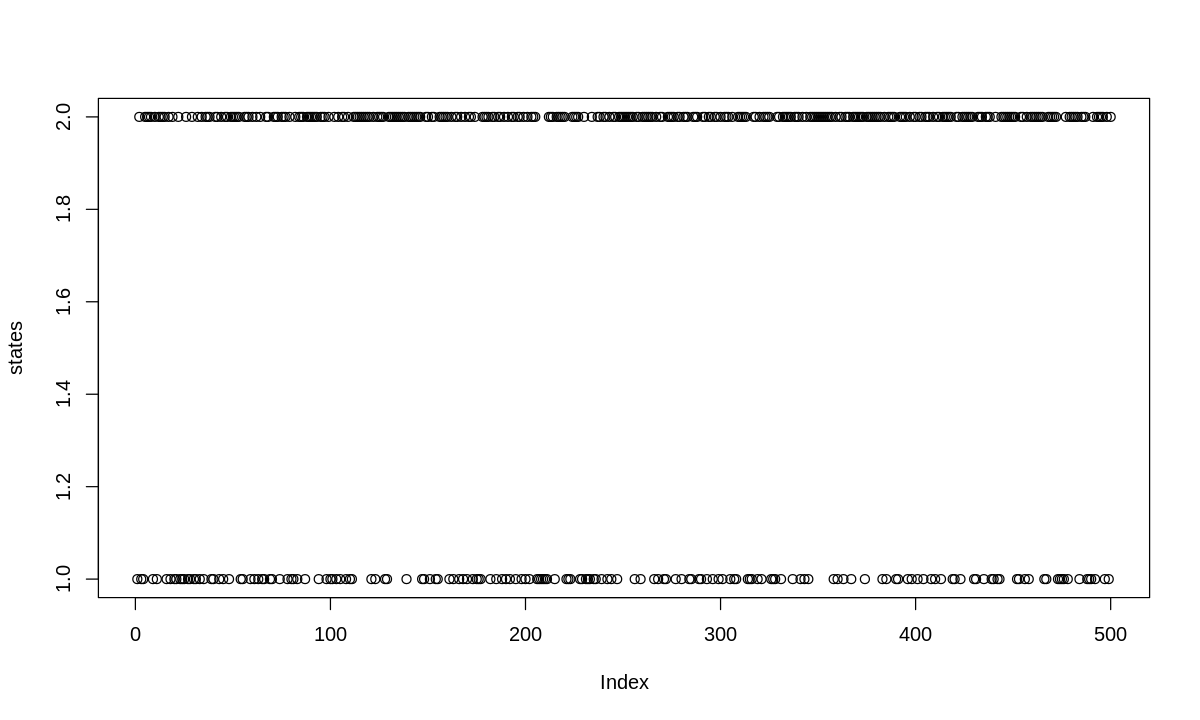

In [3]:
states <- run.mc.sim(P,500)
plot(states)


### Probabilidad de trayectoria

La probabilidad de observar una cierta secuencia de estados $x^n=(x_0,\ldots,x_n)$ está dada por:

$$p(x^n) = p(x_0)p_{x_0,x_1}p_{x_1,x_2} \cdots p_{x_{n-1},x_m} = p(x_0)\prod_{k=1}^n p_{x_{k-1},x_k}$$

Aquí $p(x_0) = P(X_0 = x_0)$ se le conoce como distribución inicial de la cadena de Markov.

Por la propiedad anterior, la probabilidad de una secuencia cualquiera $x$ está completamente determinada por:

 * La distribución incial $p(x_0) = \delta(x_0)$ (como comienza la cadena).
 * La matriz de transiciones $P$.

### Distribución de las observaciones

Resta definir como se comportan las observaciones $Y_t$ a partir de los estados. Vamos a asumir que:

 * Dado $X_t=x_t$, existe una densidad $b(y\mid x_t)$ que explica la distribución de $Y_t$. (Por ejemplo, $Y$ es gaussiana de cierta media y varianza que dependen de $x_t$).
 
 * Dada la trayectoria $x^n$, todas las observaciones son independientes entre sí (es decir, el valor de la observación no altera la dinámica).
 
Matemáticamente, se tiene que:

$$p(y^n | x^n )  = \prod_{k=0}^n b(y_k | x_k )$$

### Distribución de la observación y distribución conjunta.

De lo anterior se deduce que la distribución conjunta es:

$$p(x^n,y^n) = p(y^n\mid x^n)p(x^n) = p(x_0)b(y_0\mid x_0) \prod_{k=1}^n p_{x_{k-1},x_k}b(y_k | x_k )$$

Por último, la distribución marginal de las observaciones está dada por:

$$p(y^n) = \sum_{x^n} p(x^n,y^n).$$

Esta última es muy difícil de calcular ya que la suma es en todas las posibles trayectorias de la cadena (un número exponencialmente grande). Sin embargo, existen técnicas recursivas que simplifican su cálculo.

### Ejemplo

Consideremos una cadena $X$ como la anterior con dos estados, y con distribución inicial arrancando en el estado $1$ con probabilidad $1$ ($\delta = (1,\, 0)$).

Supongamos que $Y$ es gaussiana dada por:

$$Y_t \sim \mathcal{N}(\mu(X),\sigma^2)$$

donde $\mu(X)$ es una media que depende del estado y $\sigma^2$ es una varianza homogénea. Tomemos por ejemplo $\mu(1) = 1$, $\mu(2) = -1$ y $\sigma^2=1$. 

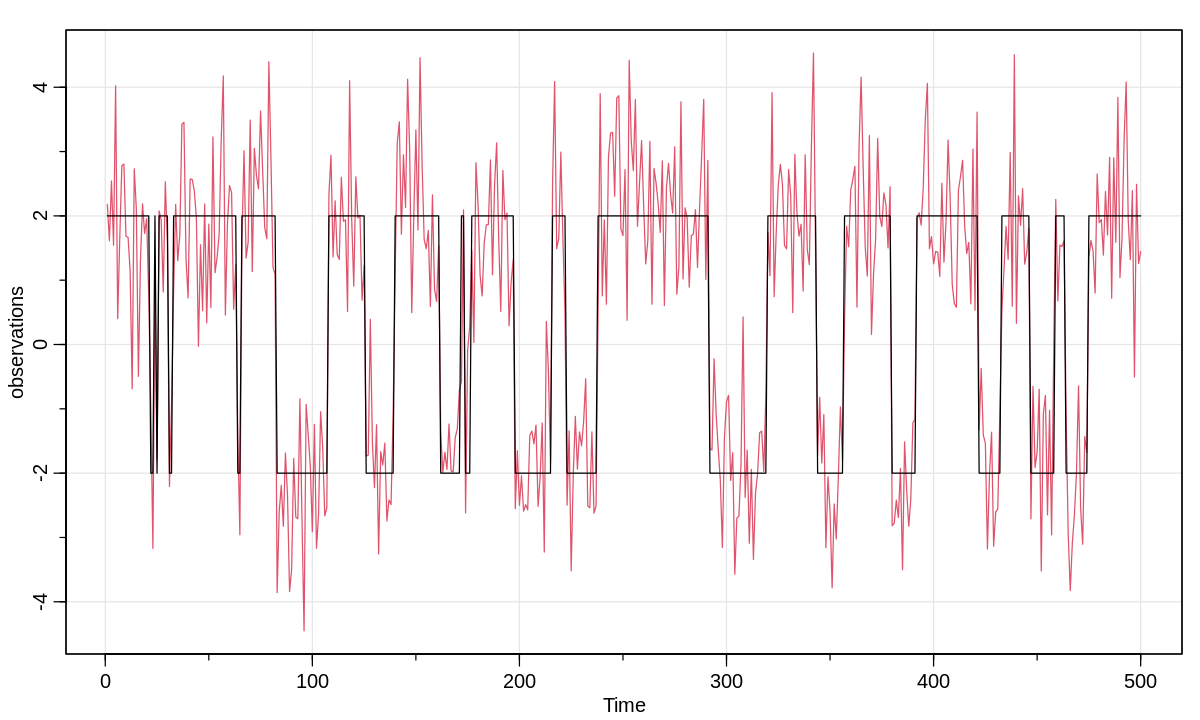

In [4]:
n=500

P <- t(matrix(c( 0.95, 0.05 ,
                 0.1, 0.9 ), nrow=2, ncol=2))

mu= c(2,-2)
sigma = 1

states <- run.mc.sim(P,n)
observations <- numeric(n)

for(k in 1:n) {
    observations[k] <-  rnorm(1, mean=mu[states[k]], sd=sigma)
}

#grafico las observaciones
tsplot(observations,col=2)

#grafico las lineas con la media de cada estado para ver la cadena escondida
lines(mu[states])

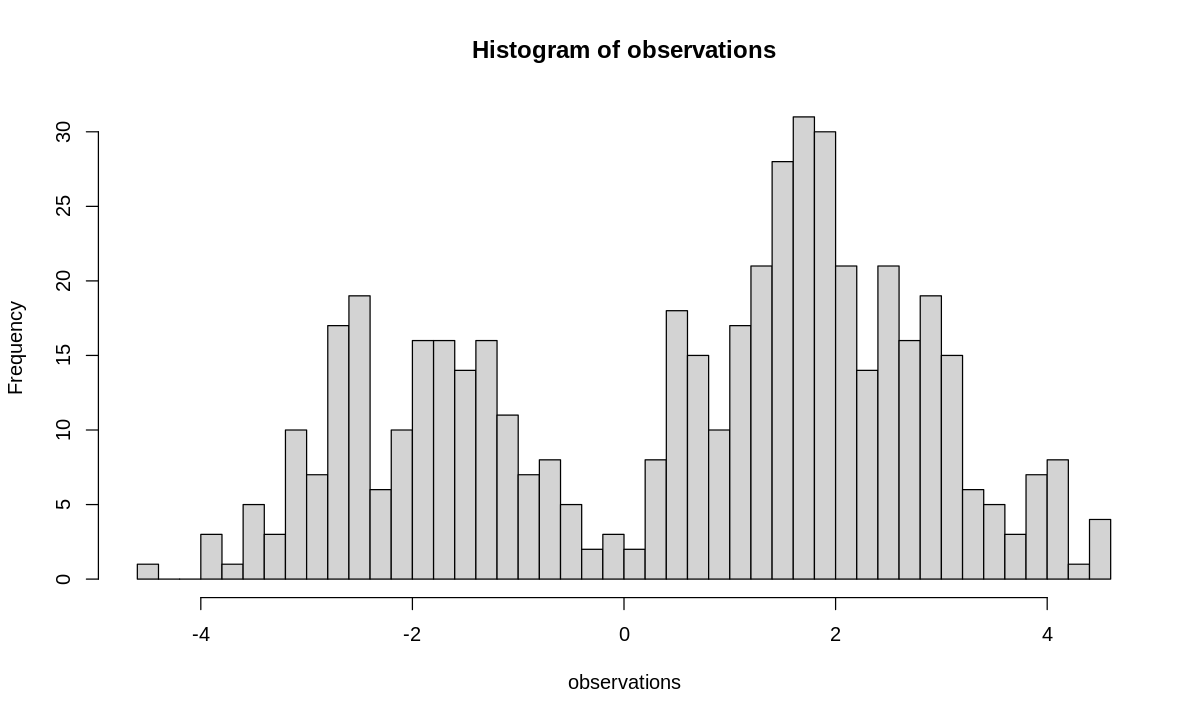

In [5]:
hist(observations,breaks=40)

El ejemplo anterior fue hecho "a mano", se puede hacer casi lo mismo usando la biblioteca `HiddenMarkov` [(documentacion)](https://cran.r-project.org/web/packages/HiddenMarkov/HiddenMarkov.pdf) de `R`. El único problema es que cuando simula *no guarda el estado escondido*, simplemente genera las observaciones, por lo que no podemos evaluar si la reconstrucción es buena.

In [6]:
install.packages("HiddenMarkov")
library("HiddenMarkov")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



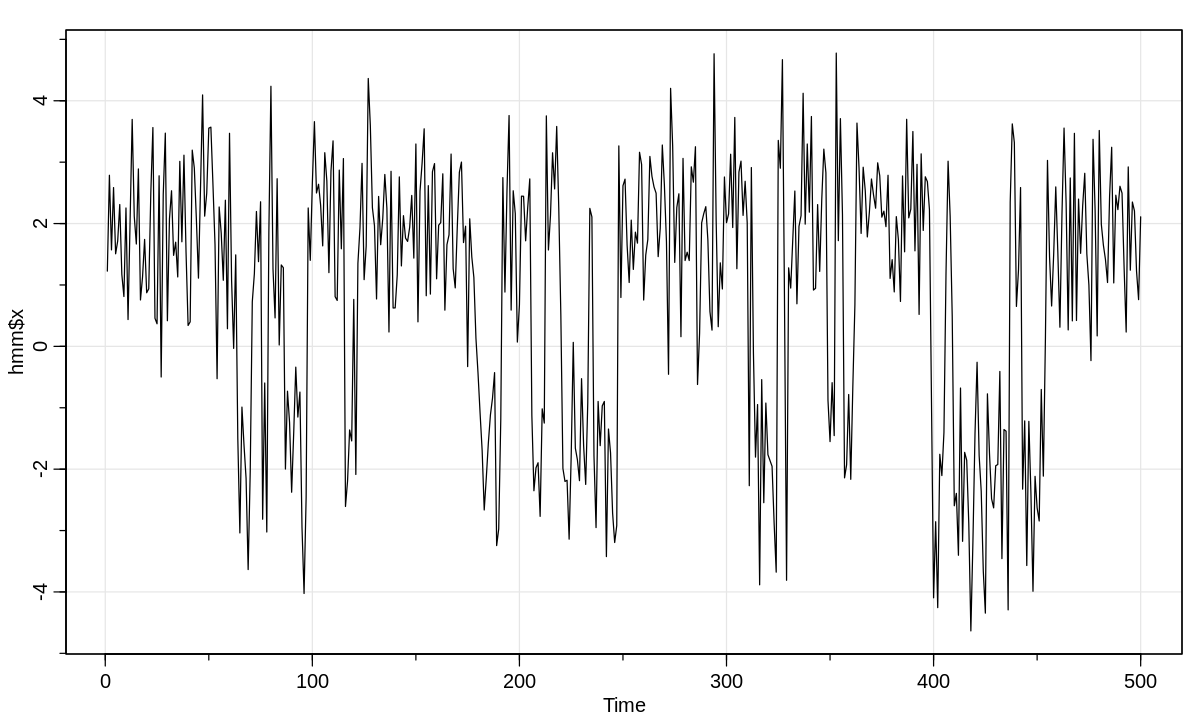

In [7]:
#construyo los parametros
P <- matrix(c(0.95, 0.05, 0.1, 0.9),byrow=TRUE, nrow=2)
delta <- c(1, 0)

#construyo la cadena y le doy la distribucion en cada estado
hmm <- dthmm(NULL, P, delta, "norm", list(mean=c(2, -2), sd=c(1,1)))
hmm <- simulate(hmm, nsim=500)
tsplot(hmm$x)

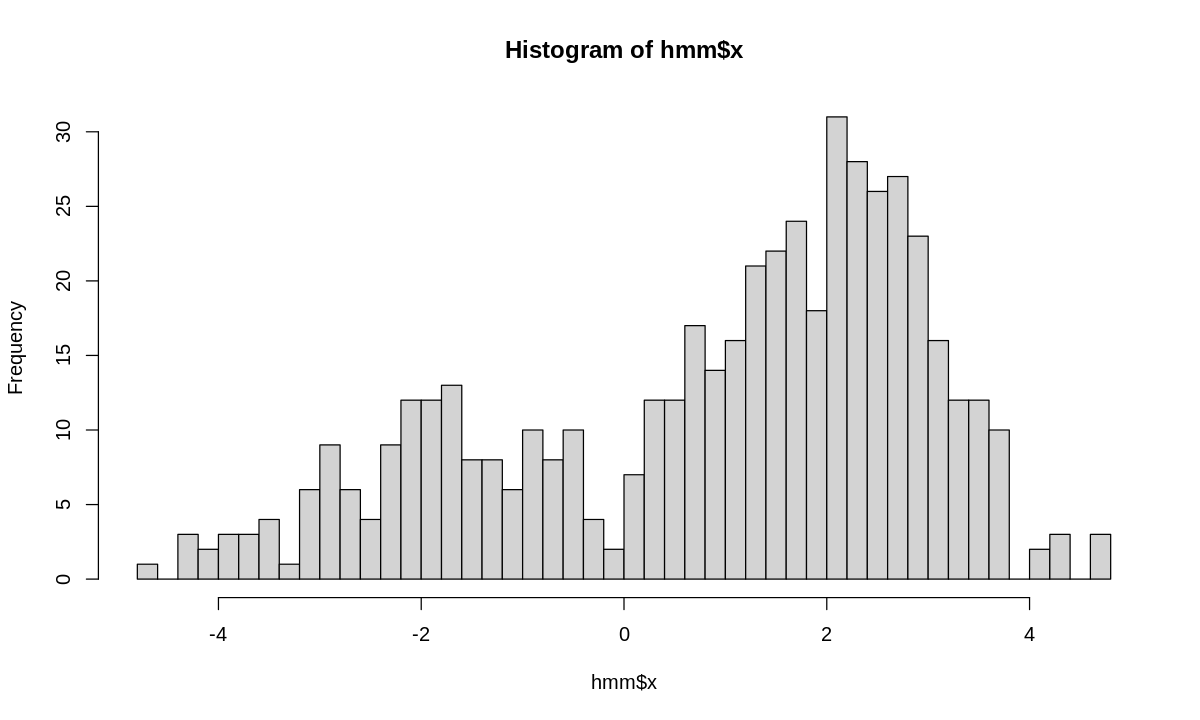

In [8]:
hist(hmm$x, breaks=40)

## Reconstrucción del estado

El primer problema que se presenta es: dadas las observaciones $y^n$, ¿es posible reconstruir los estados $x^n$ que las generan?

Si tengo $y^n = (y_0,\ldots,y_n)$ se separa en tres problemas:

 * Filtrado (filtering): hallar $x_n$, el estado "actual".
 * Suavizado (smoothing): hallar $x_k$ para $k<n$, es decir, reconstruir la cadena.
 * Predicción (prediction): hallar la distribución de probabilidad de $x_{n+1}$, $x_{n+2}$, etc. 

### Probabilidad condicional de estado.

La idea de estas ecuaciones es permitir calcular:

$$ p(x_k \mid y^n) = p(x_k \mid y_0,\ldots,y_n)$$

es decir, la probabilidad condicional de encontrar la cadena en $x_k$ en tiempo $k$ dada toda la lista de observaciones.

Luego podemos "reconstruir" eligiendo el *máximo a posteriori*:

$$x_k = \arg\max\{p(j \mid y^n), \quad j\in E\},$$

es decir, el estado que maximiza las chances de haber sido el correcto.

### Calculo de la probabilidad condicional: ecuaciones forward-backward

Haciendo un uso agresivo de la regla de Bayes se llega a la siguiente recurrencia para calcular las probabilidades condicionales.

#### Ec. forward, permiten calcular las probabilidades de filtrado ($k=n$)

$$p(x_0\mid y_0) = \frac{b(y_0\mid x_0)\delta(x_0)}{\sum_{x'_0}b(y_0\mid x'_0)\delta(x'_0)}$$

$$p(x_{k+1}\mid y^k) = \sum_{x_k} p(x_k\mid y_k) p_{x_{k},x_{k+1}}$$

$$p(x_{k+1}\mid y^{k+1}) = \frac{b(y_{k+1}\mid x_{k+1})p(x_{k+1}\mid y_k)}{\sum_{x'_{k+1}} b(y_{k+1}\mid x'_{k+1})p(x'_{k+1}\mid y_k)}$$

#### Ec. backward, permiten calcular las probabilidades de suavizado ($k<n$)

$$p(x_k,x_{k+1}\mid y^n) = p(x_k \mid y^k) \frac{p_{x_k,x_{k+1}} p(x_{k+1}\mid y^n )}{p(x_{k+1}\mid y_k)}$$ 

$$p(x_k \mid y^n) = \sum_{x_{k+1}} p(x_k,x_{k+1}\mid y^n).$$

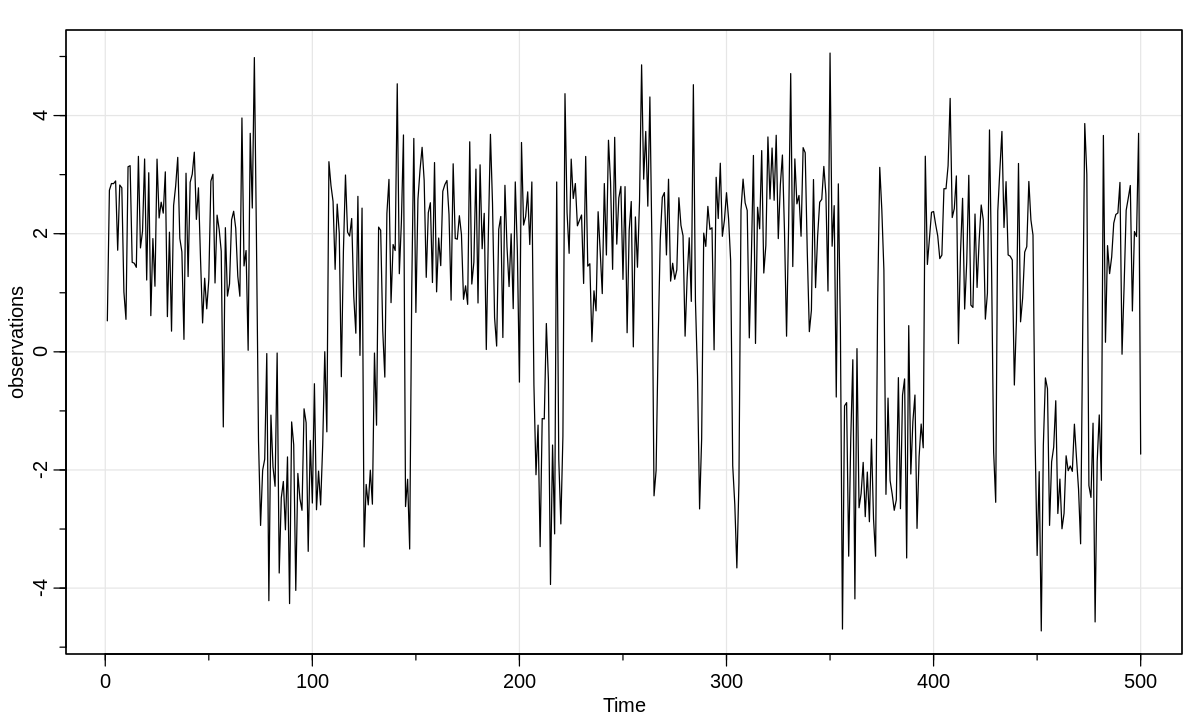

In [9]:
#Genero las observaciones a mano para poder saber el estado que dio lugar
# a las mismas (HiddenMarkov no lo guarda, ver comentario anterior)

n=500

P <- t(matrix(c( 0.95, 0.05 ,
                 0.1, 0.9 ), nrow=2, ncol=2))

mu= c(2,-2)
sigma = c(1,1)

states <- run.mc.sim(P,n)
observations <- numeric(n)

for(k in 1:n) {
    observations[k] <-  rnorm(1, mean=mu[states[k]], sd=sigma[states[k]])
}

tsplot(observations)

#Construyo el objeto HMM a partir de las observaciones simuladas externamente
hmm <- dthmm(observations, P, delta, "norm", list(mean=mu, sd=sigma))

In [10]:
### Ejemplo

#aplico forward-backward: devuelve el log de las probabilidades.
fb<- forwardback(hmm$x, P, delta, "norm", list(mean=mu, sd=sigma))

#calculo la verosimilitud logaritmica de cada estado 
#utilizando la parte forward (logalpha) y la parte backward (logbeta)

ll = fb$logalpha+fb$logbeta

#Construyo un vector de resultados
xhat = numeric(n)

#Pongo el estado más probable (el de mayor verosimilitud) en cada lugar de xhat
for (k in 1:n) {
    
    if (ll[k,1]>ll[k,2]) {
        
        xhat[k] = 1
    
    } else {
    
        xhat[k] = 2
    
    }
    
}


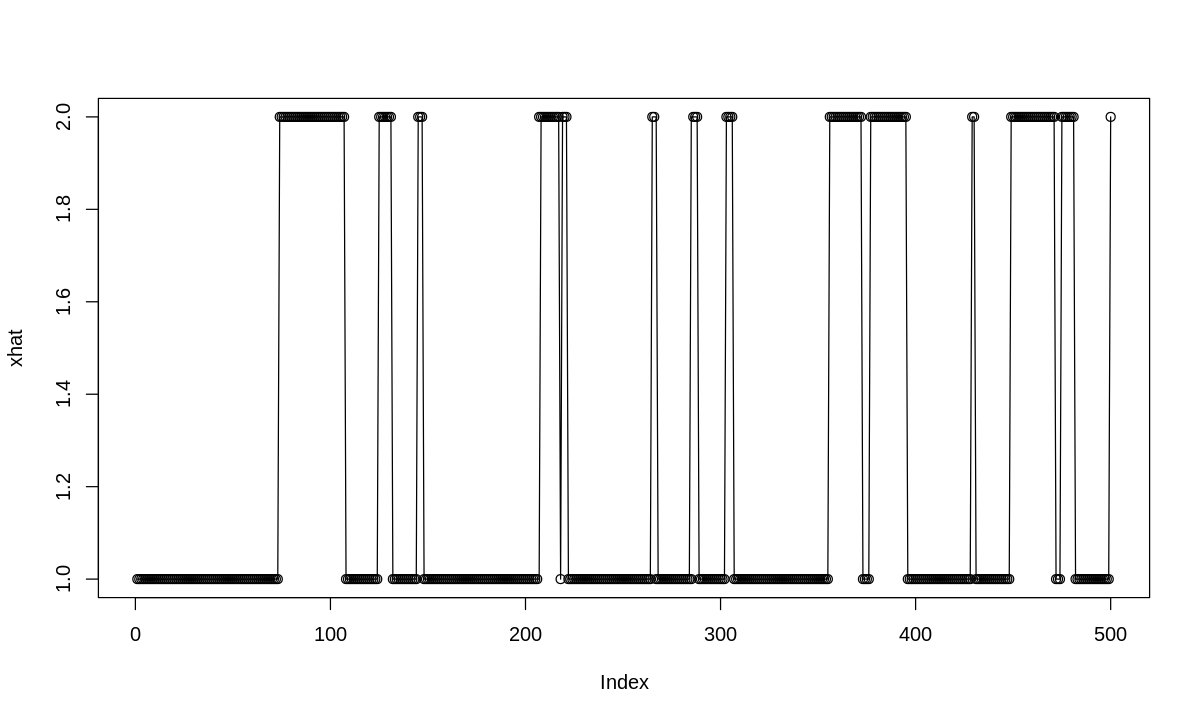

In [11]:
#Ploteo la estimacion (puntos) y el estado real (lineas)
plot(xhat)
lines(states)
    

### Algoritmo de Viterbi para reconstrucción.

El algoritmo de Viterbi es una manera inteligente de obtener toda la secuencia $x^n$ a partir de las observaciones $y^n$ de forma que:

$$\hat{x}^n  = \arg\max\{ p(x^n\mid y^n): x^n\in E^n\}$$

es decir, la trayectoria que maximiza la verosimilitud a posteriori *entre todas las trayectorias posibles* (cant. exponencial de trayectorias).

**Observación:**

Como $p(x^n\mid y^n) = p(x^n, y^n)p(y^n)$ e $y^n$ está fijo (observación), maximizar la probabilidad a posteriori es equivalente a maximizar la probabilidad conjunta $p(x^n,y^n)$.

#### Idea 

El punto clave del algoritmo es recordar que:

$$p(x^n,y^n) = p(x_0)b(y_0\mid x_0) \prod_{k=1}^n p_{x_{k-1},x_k}b(y_k | x_k )$$

Tomando logaritmo obtenemos la log-verosimilitud conjunta en forma de suma:

$$\ell(x^n,y^n) = -\log(p(x^n,y^n)) = -\log(\delta(x_0 )b(y_0\mid x_0 ))  - \sum_{k=1}^n \log(p_{x_{k−1},x_k} b(y_k \mid x_k ))$$

Definiendo:

$$u_0(x 0 ) = − \log (\delta(x_0 )b(y_0 \mid x_0 )),$$

$$u(x_{k−1} , x_k ) = − \log(p_{x_{k−1},x_k} b(y_k \mid x_k ).$$

El costo total es:

$$U(x^n,y^n) = u_0(x_0) + \sum_{k=1}^n u(x_{k-1},x_k)$$

El problema se transforma en un problema de programación dinámica de hallar el camino más corto.

#### Algoritmo

* La trayectoria óptima para llegar al estado $x$ en tiempo $k+1$ debe pasar por algún estado en
tiempo $k$, y obviamente debe haber llegado allı́ de manera óptima (si no habrı́a una trayectoria
con menor costo). 

* Con esta idea, el costo $c_{k+1} (x)$ puede calcularse recursivamente para cada estado de la siguiente forma:

$$c_{k+1} (x) = \min_{x_k} \{c_k (x_k ) + u(x_k, x)\}.$$

* El valor de $x_k$ donde se produce el mı́nimo es el estado anterior en la trayectoria óptima que
lleva a x y lo denotaremos $\gamma_k (x)$.

* Al llegar a $k = n$, se tienen almacenados $N$ costos $c_n (x) = U (x_{n−1} , x; y^n )$ correspondientes a cada posible estado final. La trayectoria óptima se determina entonces eligiendo de estos N costos totales el más pequeño haciendo $\hat{x}_n = \arg\min  c_n (x)$ y luego recursivamente hacia atrás, $\hat{x}_k = \gamma_k(x_{k+1})$.

El algoritmo se encuentra implementado en el comando `Viterbi` de la biblioteca `HiddenMarkov`.

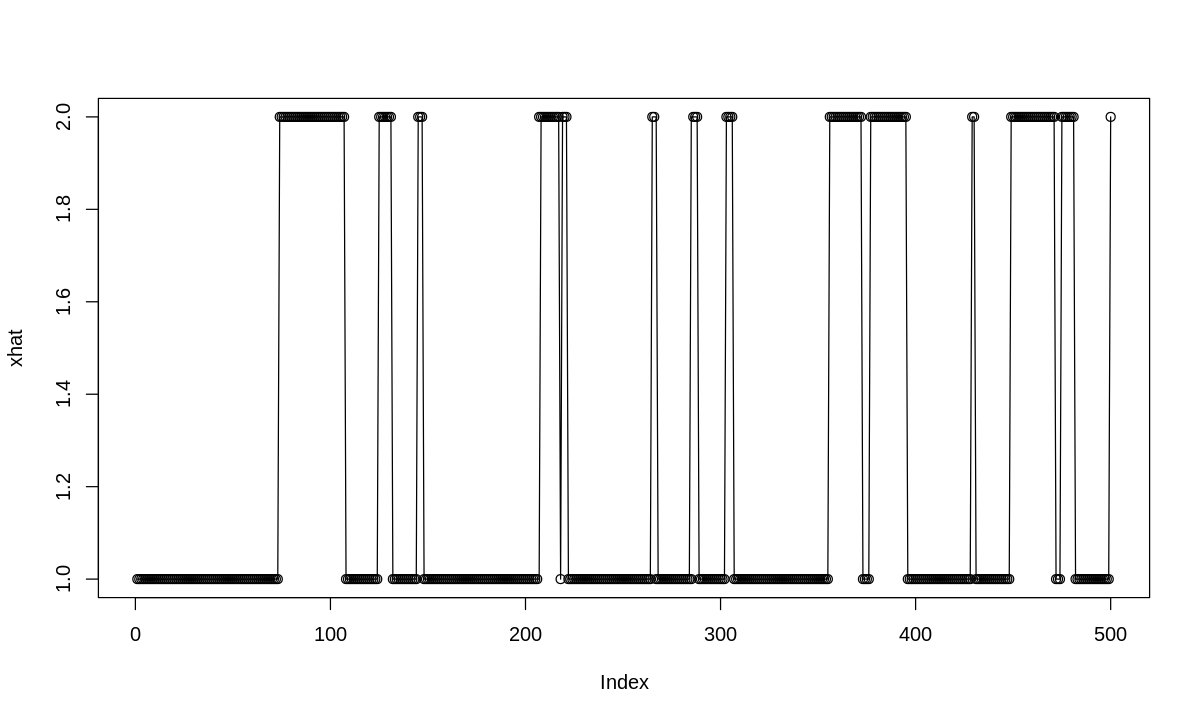

In [12]:
### Ejemplo. 

#Decodifico
xhat <- Viterbi(hmm)


#Ploteo la estimacion (puntos) y el estado real (lineas)
plot(xhat)
lines(states)

## Ajuste de modelos HMM

El otro problema relacionado a Modelos de Markov escondidos es el del ajuste de parámetros. El problema es el siguiente: dada una lista de observaciones $y^n$ de una cadena de Markov escondida, queremos identificar el conjunto de parámetros $\phi = (\delta, P, \theta)$ que da lugar a la misma:

 * $\delta$, la distribución inicial de la cadena, $\delta_i = P(X_0 = i)$.
 * $P$, la matriz de transiciones.
 * $\theta_j$, $j=1,\ldots,n$, los parámetros de las distribuciones $b(y\mid x)$ para cada posible estado. 
 
Se asume conocido el número de estados $N$, y la forma de las distribuciones $b(y\mid x)$ (Normal, Poisson, etc.)


### Algoritmos de ajuste

Existen dos grandes familias de algoritmos:

 1. El algoritmo Expectation-Maximization, que permite hallar los estimadores de máxima verosimilitud cuando existen estados escondidos en general. En el caso de su aplicación a HMM se denomina **algoritmo de Baum-Welch** y lo discutimos a continuación. Se basa en las ecuaciones forward-backward vistas arriba.
 
 2. El **algoritmo Baum-Viterbi**, que es específico de HMM. Es una variante del EM usando el algoritmo de decodificación de Viterbi visto arriba.
 
 

### Algoritmo de Baum-Welch

**Idea:** Partir de una estimación inicial aproximada de los parámetros $\phi_0$ y luego mejorarla iterativamente.

Para ello se realiza el siguiente algoritmo:

1. Construyo una estimación inicial del modelo $\phi_0$.
2. Calculo las densidades condicionales usando las ecuaciones forward-backward bajo el modelo actual $\phi_m$ (paso Expectation): 
    * $p(x_k\mid y^n) = P(X_k=x_k \mid y^n)$
    * $p(x_k,x_{k+1} \mid y^n) = P(X_k=x_k,X_{k+1}= x_{k+1}\mid y^n)$
   Estas estimaciones dan una idea de cuál es la probabilidad de haber pasado por cada estado en cada momento, suponiengo válido el modelo actual.
3. Refino el modelo construyendo $\phi_{m+1}$ reestimando por máxima verosimilitud condicional (paso Maximization):
   * $\delta_j = P(X_0=j \mid y^n)$, permite reestimar $\delta^{m+1}$, la distribución inicial.
   * $p_{ij} = \frac{\sum_{k=1}^n P(X_k=i,X_{k+1}= j\mid y^n)}{\sum_{k=1}^n P(X_k=i\mid y^n)}$ permite estimar las nuevas probabilidades de transición $P^{(m+1)}$.
   * Los nuevos parámetros $\theta_i$ de las densidades de cada estado salen de maximizar:
   $$\max_{\theta} \sum_{i=1}^N \sum_{k=0}^n \log(b(y_k\mid i;\theta_i)P(X_k=i\mid y^n)$$
   que es un problema modificado de máxima verosimilitud con pesos en las observaciones. Dicho problema tiene solución explícita para algunas distribuciones (Normal, Poisson por ejemplo) y debe resolverse numéricamente en otros casos.
4. Vuelvo al paso 2. con el $\phi_{m+1}$ estimado e itero hasta que la verosimilitud hallada no mejore.

#### Implementación

En `R`, la biblioteca `HiddenMarkov` implementa el algoritmo de Baum-Welch mediante la función `BaumWelch`. El comando:

`hmm2 = BaumWelch(hmm)` 

recibe un objeto `hmm` de tipo `dthmm` con unos parámetros iniciales y una secuencia de observaciones `y` y reajusta los parámetros usando Baum-Welch. Notar que el objeto ya pasa una cierta cantidad de estados $N$ al indicar la matriz $P$ inicial y el tipo de densidad de estado para la cual hacer la estimación (ej: Normal).

Para calcular la condición inicial, alcanza con una estimación gruesa: por ejemplo partir los estados en clases y estimar los parámetros de cada clase y las transiciones en cada una.

### Ejemplo

Apliquemos Baum-Welch a la cadena simulada más arriba. Recordemos que se generó con los parámetros:

$$\delta = (1,0) \quad P=\begin{pmatrix}0.95 & 0.05 \\ 0.1 & 0.9 \end{pmatrix} \quad b(y,1) \sim \mathcal{N}(2,1) \quad b(y,2) \sim \mathcal{N}(-2,1)$$

Pero supongamos que no conocemos **ninguno de ellos**. ¿Cómo los recuperamos de las observaciones?

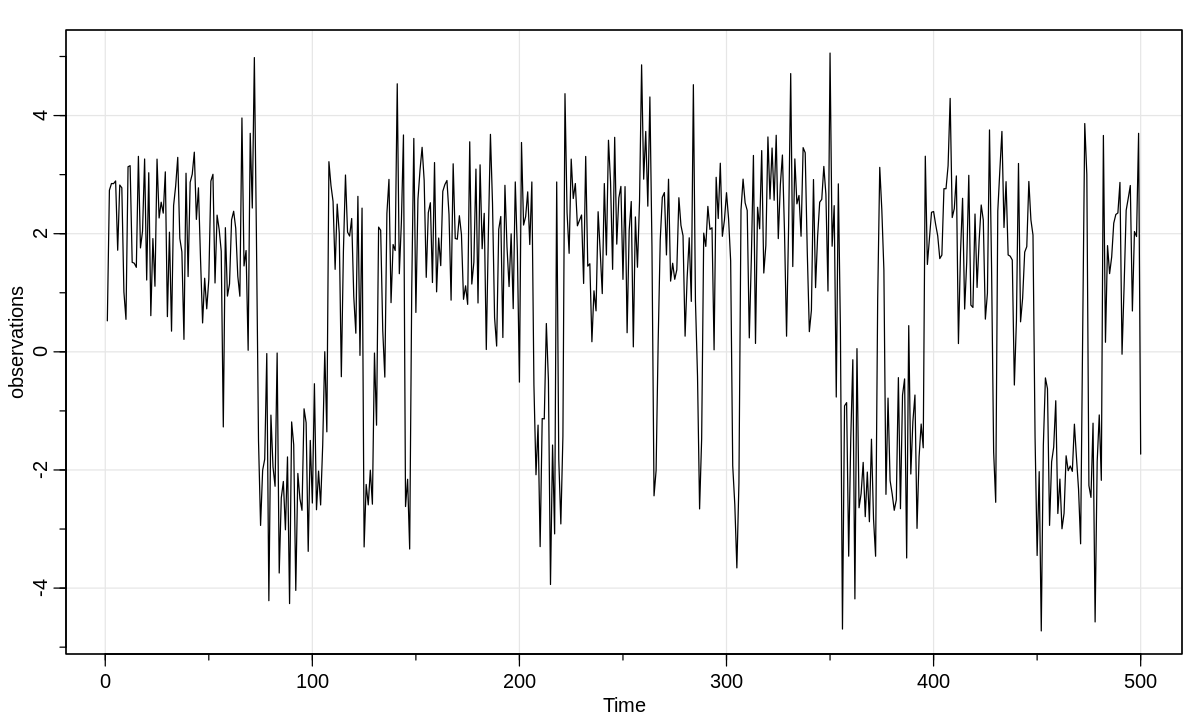

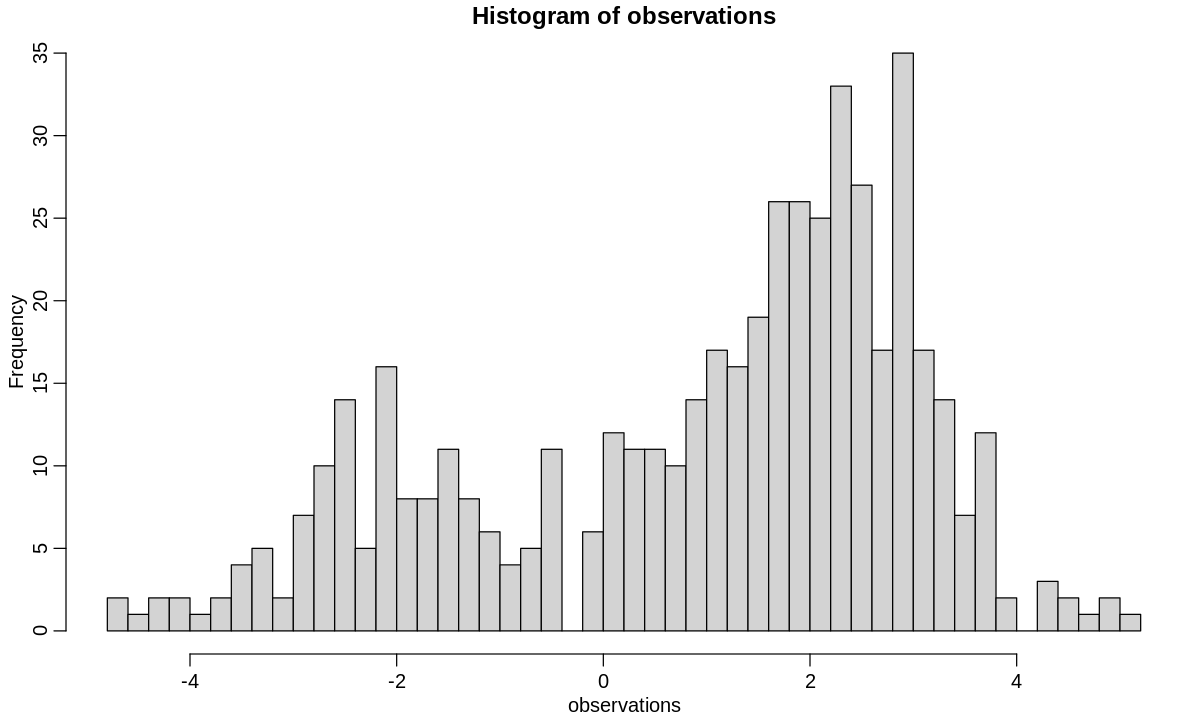

In [13]:
tsplot(observations)
hist(observations,breaks=40)

Del histograma, es bastante claro que hay dos clusters. Tomamos $0$ como umbral y etiquetamos cada observacion con un estado candidato:

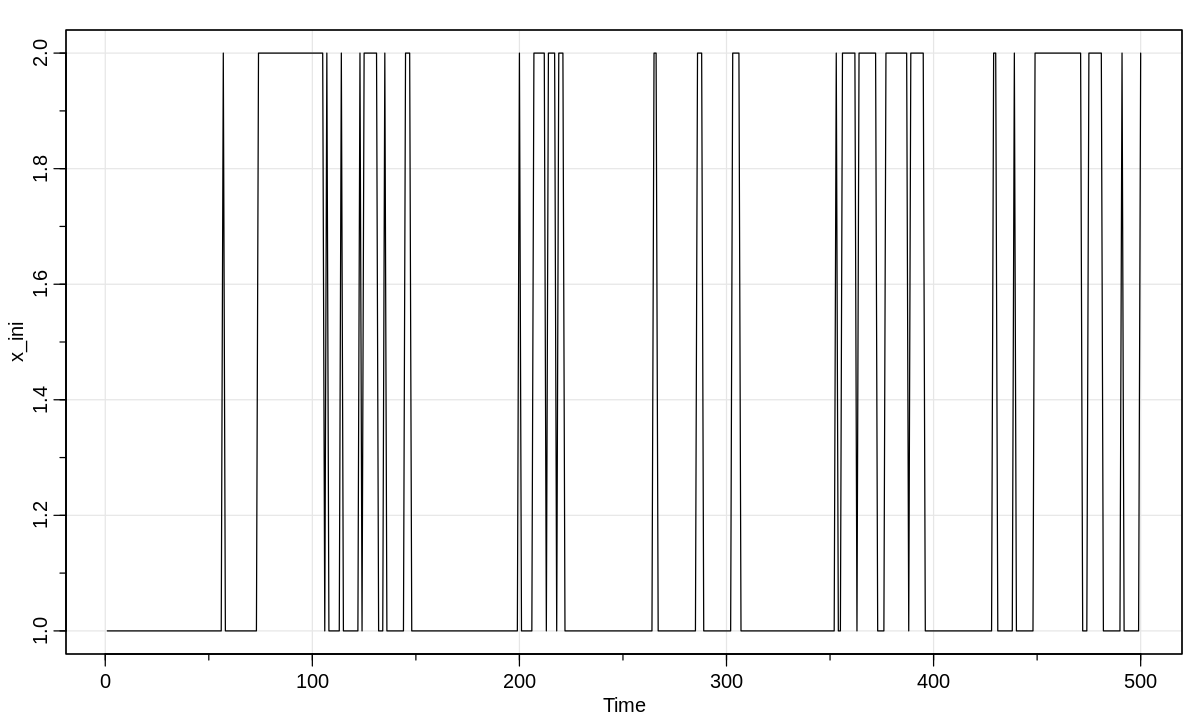

In [14]:
x_ini<- ifelse(observations>=0, 1, 2)
tsplot(x_ini)

Luego estimamos la matriz $P$ y el vector condición inicial $\delta$ como:

 * $p_{ij} = \frac{\#\{\text{saltos } i\to j\}}{\#\{\text{visitas a } i\}}$. Abajo se da la función `trans.matrix` para implementar esto.
 * $\delta_i = 1$ si la cadena arranca en el estado $i$. 

In [15]:
# Esta funcion permite estimar la matriz de transiciones contando los saltos de estado.
trans.matrix <- function(X)
{
    X<-t(as.matrix(X))
    tt <- table( c(X[,-ncol(X)]), c(X[,-1]) )
    tt <- tt / rowSums(tt)
}

In [16]:
#Construyo una estimacion inicial de la matriz
P_ini=trans.matrix(x_ini)
P_ini

   
             1          2
  1 0.92777778 0.07222222
  2 0.17985612 0.82014388

In [17]:
#Asigno probabilidad 1 al estado donde inicia la cadena.
delta_ini = as.numeric(x_ini[1] == (1:2))
delta_ini

[1] 1 0

Ahora que tenemos los estados clasificados, también podemos hacer una estimación inicial de la media y la desviación estándar de la gaussiana que se observa en cada estado como:

In [18]:
#Extraigo la media y la desviacion estandar del comportamiento en cada estado asignado
mu1 = mean(observations[x_ini==1])
mu2 = mean(observations[x_ini==2])
sigma1 = sd(observations[x_ini==1])
sigma2 = sd(observations[x_ini==2])

mu_ini = c(mu1,mu2)
sigma_ini = c(sigma1,sigma2)

mu1
mu2
sigma1
sigma2

[1] 2.088524

[1] -2.002414

[1] 1.015088

[1] 1.066094

Ahora construimos un objeto `hmm` con la estimacion inicial de la cadena, y la mejoramos usando Baum-Welch

In [19]:
hmm_ini <- dthmm(observations, P_ini, delta_ini, "norm", list(mean=mu_ini, sd=sigma_ini))

Con la cadena inicial estimada, corremos el algoritmo de Baum-Welch para ajustar los parámetros por máxima verosimilitud:

In [20]:
hmm_fit <- BaumWelch(hmm_ini)

summary(hmm_fit)

iter = 1 
LL = -848.5514844 
diff = Inf 

iter = 2 
LL = -842.1612903 
diff = 6.390194 

iter = 3 
LL = -841.9980067 
diff = 0.1632836 

iter = 4 
LL = -841.9945017 
diff = 0.003505041 

iter = 5 
LL = -841.9944242 
diff = 7.741372e-05 

iter = 6 
LL = -841.9944224 
diff = 1.802468e-06 



0.9596672,0.04033275
0.1003573,0.89964266


El objeto `hmm_fit` tiene ahora los parámetros ajustados y podemos recuperarlos obteniendo una mejor estimación:

In [21]:
#Parametros estimados. Notar que ajustan mejor a los valores con los cuales se genero el proceso
hmm_fit$Pi
hmm_fit$delta
hmm_fit$pm

0.9596672,0.04033275
0.1003573,0.89964266


[1] 1 0

$mean
[1]  2.057873 -2.005185

$sd
[1] 1.057581 1.098997

Por último, se puede recuperar la trayectoria de estados ya sea usando las ecuaciones forward-backward o el estimador de Viterbi. Aquí lo hacemos con Viterbi

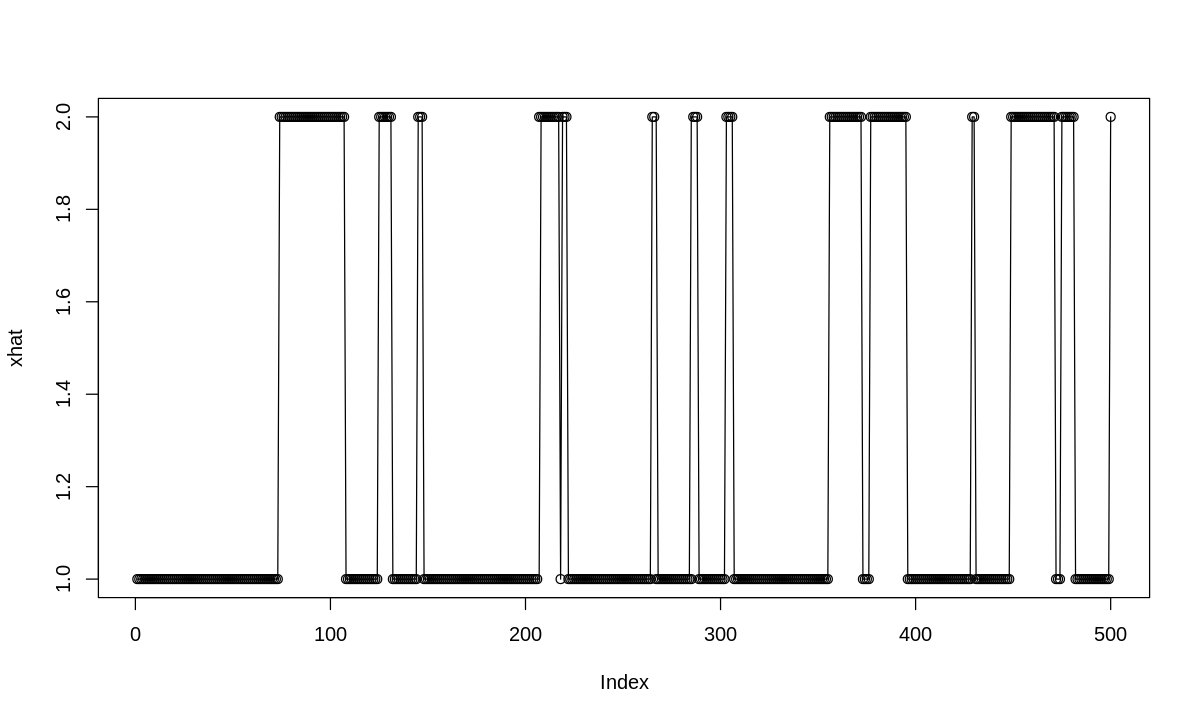

In [22]:
xhat = Viterbi(hmm_fit)

plot(xhat)
lines(states)

Podemos graficar la reconstrucción final mirando las medias halladas para cada estado:

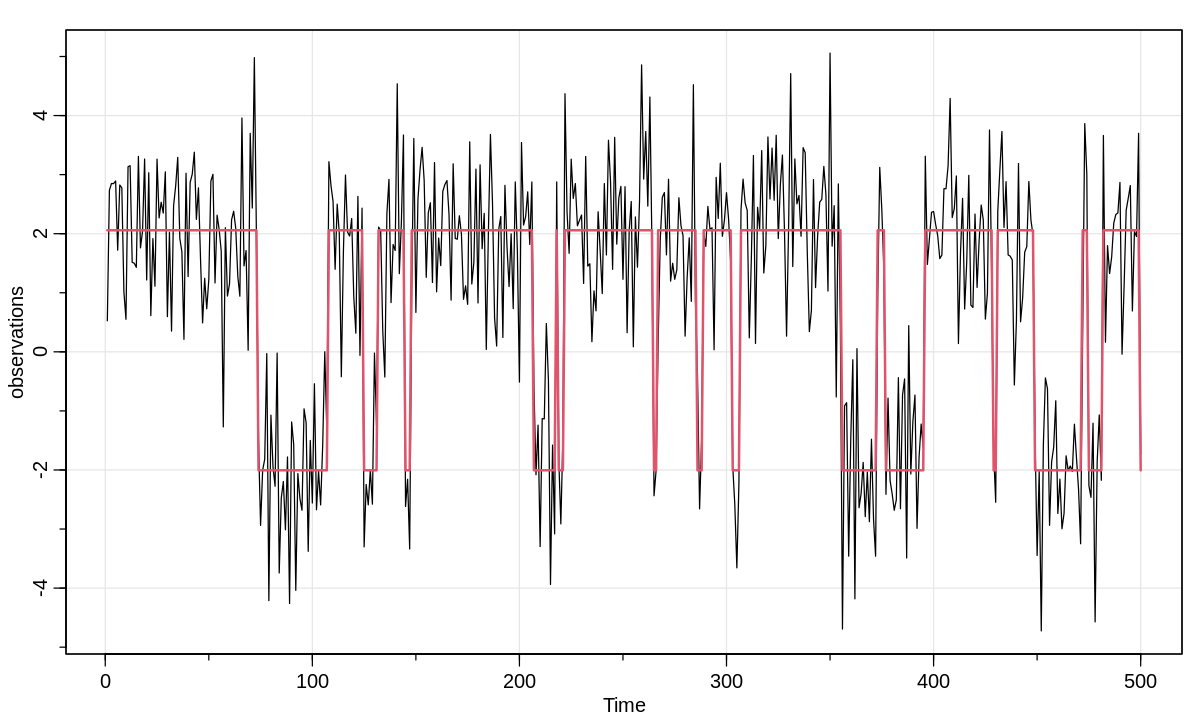

In [23]:
medias_est = hmm_fit$pm$mean

tsplot(observations)
lines(medias_est[xhat],col=2,lw=2)

### Algoritmo de Baum-Viterbi

Es una variante del algoritmo anterior. Funciona de la siguiente manera:

1. Construyo una estimación inicial del modelo $\phi_0$.
2. Se utiliza el algoritmo de Viterbi para hallar la secuencia más probable de estados para las observaciones $y^n$ y los parámetros $\phi_m$ actuales.
3. Se estima por máxima verosimilitud los nuevos parámetros $\phi$ de la siguiente manera:
  * Para la distribución inicial, simplemente se toma $\delta=1$ para el estado que Viterbi indica como inicial.
  * Para la matriz P, se hace la estimación por conteo de transiciones:
        $$p_{ij} = \frac{\#\{\text{saltos } i\to j\}}{\#\{\text{visitas a } i\}}$$
    Es decir, se aplica la función `trans.matrix`.
  * Para los parámetros de la distribución $b(y\mid x)$, se utiliza el estimador de máxima verosimilitud (por ejemplo, el promedio para la media) separando las observaciones en los estados identificados por Viterbi.
4. Vuelvo al paso 2. con el $\phi_{m+1}$ estimado e itero hasta que la verosimilitud hallada no mejore.

#### Implementación

Lamentablente este algoritmo, a pesar de ser sencillo, no está implementado en la biblioteca `HiddenMarkov`. Damos a continuación una implementación.

In [24]:
baum_viterbi_normal <- function(hmm_ini,tol=1e-3,maxiter=10) {
    
    paso = Inf #incremento de la verosimilitud
    k = 0 #no. de iteracion
    N = nrow(hmm_ini$P) #no. de estados
    
    hmm_fit = hmm_ini #en hmm_fit guardo la salida. Arranca igual a hmm_ini
    
    while (paso>tol && k<maxiter) {

        lL_ini =  logLik(hmm_fit) #guardo la verosimilitud anterior
        x = Viterbi(hmm_fit) #recupero los estados mas probables
      
        #Reestimo los parametros:
        delta = as.numeric(x[1] == (1:N))
        P = trans.matrix(x)

        #Construyo un vector para medias y varianzas y los lleno con los estimadores filtrando por estado
        mus = vector()
        sigmas = vector()
        for (i in 1:N) {
            mus[i] = mean(hmm_fit$x[x==i])
            sigmas[i] = sd(hmm_fit$x[x==i])
        }
 
        hmm_fit = dthmm(hmm_fit$x, Pi=P, delta=delta, distn="norm", pm= list(mean=mus, sd=sigmas))
        paso = abs(logLik(hmm_fit)-lL_ini) #calculo cuanto mejora la verosimilitud
        k = k+1 #incremento el contador de iteraciones
        
        print(paste("Paso: ",k))
        print(paste("Verosimilud: ",logLik(hmm)))
    }
    return(hmm_fit)
}

Corremos ahora el algoritmo Baum-Viterbi arrancando de la estimación inicial `hmm_ini` que habíamos construido:

In [25]:
hmm_fit2 = baum_viterbi_normal(hmm_ini)

[1] "Paso:  1"
[1] "Verosimilud:  -845.29965721463"
[1] "Paso:  2"
[1] "Verosimilud:  -845.29965721463"
[1] "Paso:  3"
[1] "Verosimilud:  -845.29965721463"


In [26]:
#Notar que esta estimación es levemente distinta a la de Baum-Welch.
summary(hmm_fit2)

$delta
[1] 1 0

$Pi
   
             1          2
  1 0.96153846 0.03846154
  2 0.09629630 0.90370370

$nonstat
[1] TRUE

$distn
[1] "norm"

$pm
$pm$mean
[1]  2.051754 -2.024323

$pm$sd
[1] 1.063536 1.086314


$discrete
[1] FALSE

$n
[1] 500


Por último, se puede recuperar la trayectoria de estados nuevamente haciendo Viterbi sobre el objeto ajustado:

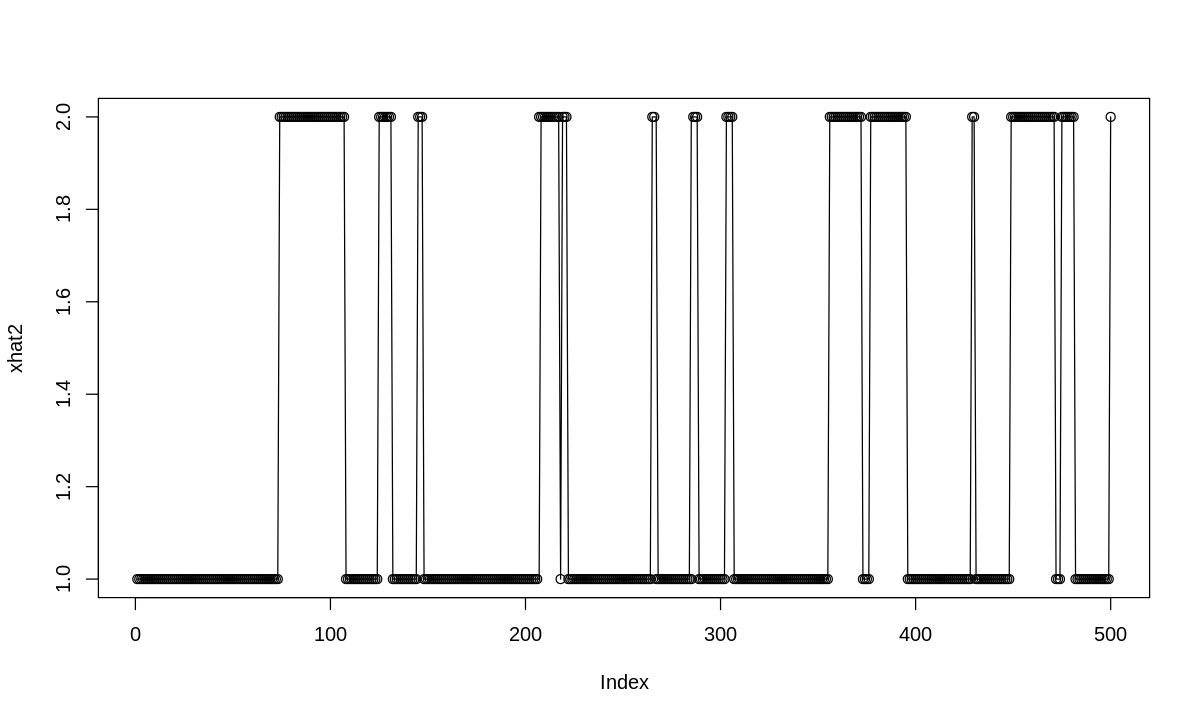

In [27]:
xhat2 = Viterbi(hmm_fit2)

plot(xhat2)
lines(states)

Y también graficar la reconstrucción final mirando las medias halladas para cada estado (notar que la reconstrucción coincide con la anterior en este caso):

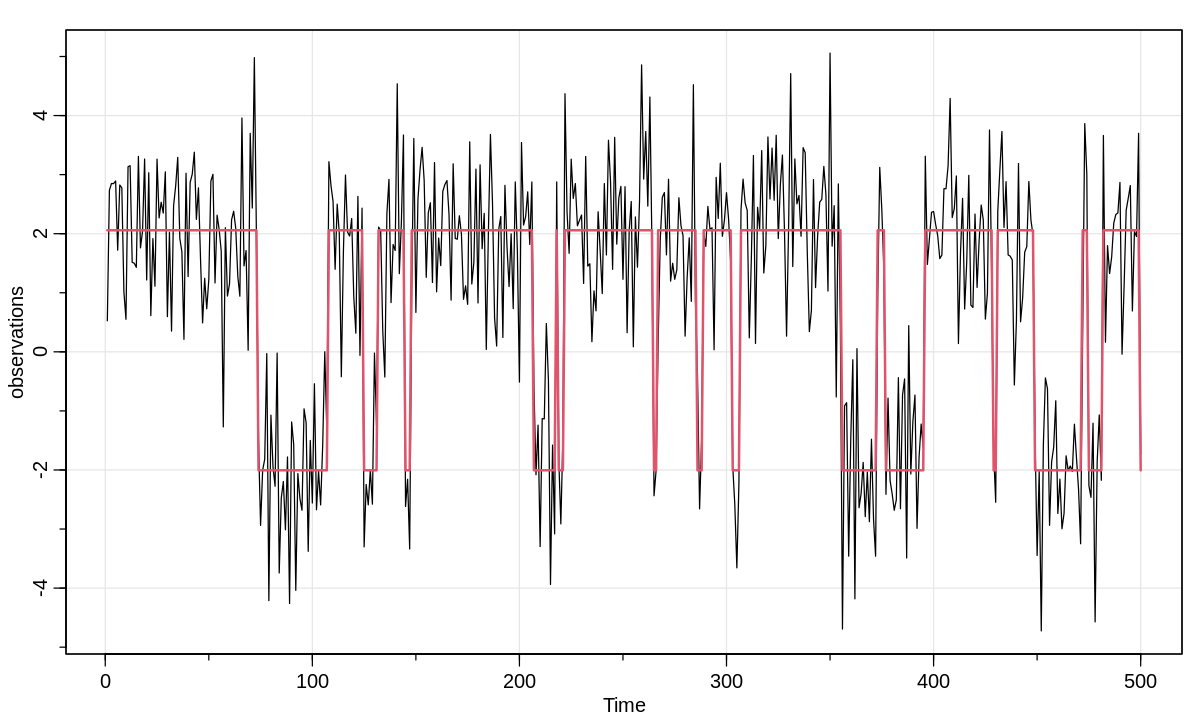

In [28]:
medias_est_2 = hmm_fit$pm$mean

tsplot(observations)
lines(medias_est_2[xhat2],col=2,lw=2)

## Ejercicio

Se desea realizar un modelo para la llegada de pacientes diarios a la emergencia de un hospital. Podemos suponer que:

 * El estado oculto de "demanda" es bajo, medio o alto. El estado de demanda solo puede cambiar de bajo a medio o medio a alto, o en sentido inverso (es decir, no se puede ir de bajo a alto directamente).
 
 * En promedio, la demanda se mantiene en el mismo estado por una semana. En el caso del estado "medio" va a "bajo" o "alto" con igual probabilidad.
 
 * Para cada estado, la cantidad de pacientes que llegan a la emergencia es una v.a. Poisson con media $\lambda_{bajo} =50$, $\lambda_{medio} = 75$ y $\lambda_{alto}=100$.
 
 * Se asume que la demanda comienza en estado "bajo".
 

1. Construir el modelo de HMM Poisson usando el comando `hmm = dthmm(NULL, P,delta,"pois",pm=list(lambda=lambdas))` donde `P`, `delta` y `lambdas` son los correspondientes al modelo anterior.

2. Simular una realización de la cadena durante un año usando `hmm = simulate(hmm,365)`.

3. Plotear las observaciones obtenidas (`hmm$x`) y realizar un histograma para evaluar clusters.

4. Realizar una estimación en 3 estados iniciales usando umbrales adecuados, y realizar una primera estimación `hmm_ini` de la cadena. Puede usarse como guía el ejemplo de Gaussianas anterior y la función `trans.matrix` para estimar $P$.

5. Mejorar la estimación usando Baum-Welch y Baum-Viterbi (pueden usarse los ejemplos y las funciones de más arriba). Comparar con la matriz P original y las medias originales.
 
6. Estudiar la estimación de estados lograda. Se puede comparar con los estados "oficiales" que quedan en `hmm$y`.


**Nota:** Para hacer Baum-Viterbi se debe modificar adecuadamente la función `baum_viterbi_normal` para usar la distribución Poisson. Esto implica que la cadena `hmm_fit` debe construirse con `distn="pois"` y debe proveerse únicamente la lista de lambdas, que se estiman por máxima verosimilitud como el promedio de las observaciones en cada estado. Baum Welch puede hacerse directamente pues ya viene programado.